## 3. Training a NN

In this part of the tutrorial, we'll be training a simple MLP on MNIST.
We'll go over the basic components for the training part:
- Datasets
- DataLoaders
- The basic training loop

In [96]:
import torch
from torch import nn

# tqdm adds support for progress bars
from tqdm import tqdm

# torchvision provides support for computer vision (datasets, transformations, models,...)
import torchvision
from torchvision import transforms as T

# torcheval provides support for evaluation metrics
from torcheval import metrics

# timm is a HuggingFace library providing a large collection of pre-trained image models (>> torchvision)
import timm

# extra libraries
from PIL import Image
import matplotlib.pyplot as plt
import os

/home/marco/miniconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We'll first download the MNIST dataset and then define the model and the training loop.

In [7]:
mnist_train = torchvision.datasets.MNIST(root="data", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root="data", train=False, download=True)

Datasets to be used in PyTorch should be subclasses of `torch.utils.data.Dataset`.

In [8]:
isinstance(mnist_train, torch.utils.data.Dataset)

True

The `Dataset` provides the basic interface to access the data and defines data augmentation/preprocessing steps:
- the `transform` attribute provides the information about the preprocessing steps to be applied to the data
- `__len__` should return the size of the dataset
- `__getitem__` should return the item at the given index **after applying preprocessing**

![](img/dataset.png)

In [16]:
mnist_train.transform is None

True

Right now, the dataset essentially contains basic images.

In [21]:
img, label = mnist_train[0]
img = img.copy()

img, label

(<PIL.Image.Image image mode=L size=28x28>, 5)

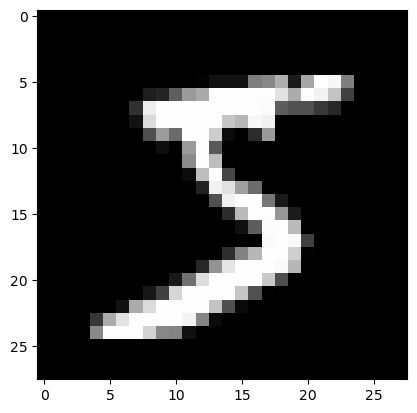

In [24]:
plt.imshow(img, cmap="gray")

We can add some basic transformations to the dataset so it can be elaborated by the dataset:

- `ToTensor` converts the image to a tensor and normalizes it in the 0-1 range. This is a **preprocessing step** since it's not deterministic. 
  - We can very well convert the whole dataset to tensors beforehand. **Question**: What prevents us from doing this?
- `RandomAffine` applies a random affine transformation (rotation + translation + scaling) to the image. This is a **data augmentation step** since it's non-deterministic and we want to apply it on the fly.

In [23]:
transforms = T.Compose([
    T.ToTensor(),
    T.RandomAffine(degrees=10, scale=(0.9, 1.1)),
])

mnist_train.transform = transforms

Text(0.5, 1.0, 'Transformed')

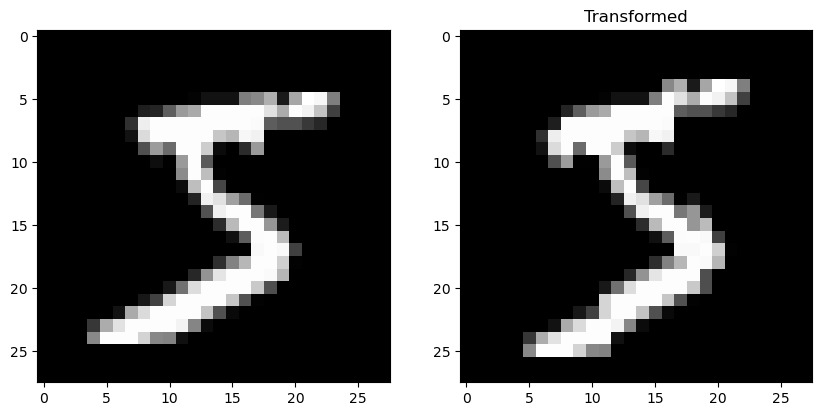

In [34]:
img2, label = mnist_train[0]

# plot 2 images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img, cmap="gray")
axs[1].imshow((img2.permute(1, 2, 0) * 255).numpy().astype("uint8"), cmap="gray")
plt.title("Transformed")

We also need to add the `ToTensor` transformation to the `test_transform` since we want to convert the images to tensors before feeding them to the model.

In [38]:
mnist_test.transform = T.ToTensor()

To train a model using SGD, we need to pack the data into batches. This is done using `DataLoader` which is a subclass of `torch.utils.data.DataLoader`.

In [40]:
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)


A DataLoader implements the iterator pattern in a **lazy way** (using a generator):
- We cannot access the batches directly (e.g., `trainloader[0]` does not work)
- We create a dataset by iterating over the DataLoader or by calling the `next` method on `iter(dataloader)`

In [41]:
for i, batch in enumerate(trainloader):
    print(f"Batch {i+1}", batch[0].shape, batch[1].shape)
    

Batch 1 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 2 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 3 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 4 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 5 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 6 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 7 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 8 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 9 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 10 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 11 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 12 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 13 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 14 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 15 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 16 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 17 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 18 torch.Size([64, 1, 28, 28]) torch.Size([64])
Batch 19 torch.Size([64, 1, 28, 28]) 

Let's now define the model. We'll be using a simple MLP with 3 hidden layers, relu activations, and batch normalization.

In [82]:
mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 16),
    nn.ReLU(),
    nn.BatchNorm1d(16),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.BatchNorm1d(16),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.BatchNorm1d(16),
    nn.Linear(16, 10)
)

Additionally, our model needs an **optimizer** to update the weights. We'll use the `torch.optim.SGD` optimizer.

In [83]:
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

We can now build the training loop.

We define a number of epochs for training. In each epoch, we'll *regenerate* the trainloader to redo the batches and apply the random transformations to the images.

```python
for epoch in range(epochs):
    for data, labels in trainloader:
        ...
```

Within the inner loop, we will need to do the following things:
- Zero out the gradients from the previous iteration
- Do the forward pass
- Compute the loss
- Do the backward pass
- Update the weights



In [71]:
epochs = 3

In [ ]:
mlp.train() # IMPORTANT: this sets the model to training mode --- useful for batchnorm and dropout

for epoch in range(epochs):
    for data, labels in trainloader:
        # inner loop
        pass

It is often useful to compute some other metrics while the model is training.

We can use `torcheval` functionalities to keep track of accuracy and loss.

In addition, we can use `tqdm` to display a progress bar.

We will also anneal the learning rate at the end of each epoch.

In [ ]:
mlp.train() # IMPORTANT: this sets the model to training mode --- useful for batchnorm and dropout

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1) # will anneal LR by 0.1 each time scheduler.step() is called

for epoch in range(epochs):
    accuracy_counter = metrics.MulticlassAccuracy()
    loss_counter = metrics.Mean()

    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")
    for data, labels in progress_bar:
        # some code here

        accuracy_counter.update(predictions, labels)
        loss_counter.update(loss, weight=data.size(0))

        progress_bar.set_postfix(
            loss=loss_counter.compute().item(),
            accuracy=accuracy_counter.compute().item()
        )
    scheduler.step() # anneal LR by 0.1


    


Epoch 3/3: 100%|██████████| 938/938 [00:18<00:00, 51.78it/s, accuracy=0.921, loss=0.263]


Test evaluation is done in a similar way to the training loop.

In [ ]:
mlp.eval() # IMPORTANT: this sets the model to evaluation mode --- useful for batchnorm and dropout

accuracy_counter = metrics.MulticlassAccuracy()
loss_counter = metrics.Mean()

progress_bar = tqdm(testloader, desc=f"Eval 1/1")
for data, labels in progress_bar:
    with torch.no_grad(): # force no gradients
        # some code here


        accuracy_counter.update(predictions, labels)
        loss_counter.update(loss, weight=data.size(0))

        progress_bar.set_postfix(
            loss=loss_counter.compute().item(),
            accuracy=accuracy_counter.compute().item()
        )

Epoch 3/3: 100%|██████████| 157/157 [00:00<00:00, 235.10it/s, accuracy=0.945, loss=0.18] 


Let's bundle together all the components to train and eval the model

In [ ]:
def train(model, optimizer, scheduler, trainloader, epochs):
    model.train()
    for epoch in range(epochs):
        accuracy_counter = metrics.MulticlassAccuracy()
        loss_counter = metrics.Mean()

        progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")
        for data, labels in progress_bar:

            accuracy_counter.update(predictions, labels)
            loss_counter.update(loss, weight=data.size(0))

            progress_bar.set_postfix(
                loss=loss_counter.compute().item(),
                accuracy=accuracy_counter.compute().item()
            )
        scheduler.step()

def evaluate(model, testloader):
    model.eval()
    accuracy_counter = metrics.MulticlassAccuracy()
    loss_counter = metrics.Mean()

    progress_bar = tqdm(testloader, desc="Eval 1/1")
    for data, labels in progress_bar:
        with torch.no_grad():
            

            progress_bar.set_postfix(
                loss=loss_counter.compute().item(),
                accuracy=accuracy_counter.compute().item()
            )

### Saving and loading a model

We can save the model using `torch.save(model.state_dict(), save_path)` and load it using `model.load_state_dict(torch.load(save_path))`.

The `state_dict` is a dictionary containing the model's parameters.


In [86]:
mlp.state_dict()

OrderedDict([('1.weight',
              tensor([[-0.0192, -0.0297,  0.0338,  ...,  0.0230,  0.0002,  0.0015],
                      [ 0.0274, -0.0115,  0.0014,  ...,  0.0204,  0.0273,  0.0077],
                      [-0.0342, -0.0156,  0.0007,  ..., -0.0044,  0.0201,  0.0230],
                      ...,
                      [-0.0049, -0.0301,  0.0041,  ..., -0.0319,  0.0206,  0.0270],
                      [ 0.0324,  0.0323, -0.0011,  ...,  0.0133, -0.0038, -0.0199],
                      [ 0.0065,  0.0144, -0.0102,  ...,  0.0056, -0.0267, -0.0072]])),
             ('1.bias',
              tensor([-0.0274, -0.0193,  0.0582,  0.0075,  0.0097,  0.1184,  0.0753, -0.0574,
                       0.0827,  0.1902,  0.0269, -0.0406,  0.0780,  0.1205,  0.1526,  0.0323])),
             ('3.weight',
              tensor([0.9834, 0.9356, 0.9721, 0.9357, 0.9411, 1.0219, 0.9642, 0.9889, 0.9779,
                      1.0161, 0.9885, 0.9817, 0.9504, 1.0194, 1.0541, 1.1152])),
             ('3.bias',


In [89]:
save_path = "weights/mlp_mnist.pth"

os.makedirs(os.path.dirname(save_path), exist_ok=True)

torch.save(mlp.state_dict(), "weights/mlp_mnist.pth")

In [90]:
mlp.load_state_dict(torch.load("weights/mlp_mnist.pth"))

<All keys matched successfully>

Notice: also optimizers, schedulers, and metrics have a state_dict

In [92]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': tensor([[-1.9213e-05, -2.9726e-05,  3.3776e-05,  ...,  2.3047e-05,
             1.9870e-07,  1.4562e-06],
           [ 2.7439e-05, -1.1490e-05,  1.3584e-06,  ...,  2.0397e-05,
             2.7295e-05,  7.6733e-06],
           [-3.4180e-05, -1.5585e-05,  7.4561e-07,  ..., -4.4396e-06,
             2.0146e-05,  2.3021e-05],
           ...,
           [-4.9157e-06, -3.0065e-05,  4.0653e-06,  ..., -3.1905e-05,
             2.0638e-05,  2.6995e-05],
           [ 3.2397e-05,  3.2295e-05, -1.0880e-06,  ...,  1.3289e-05,
            -3.8246e-06, -1.9937e-05],
           [ 6.4907e-06,  1.4357e-05, -1.0200e-05,  ...,  5.6377e-06,
            -2.6719e-05, -7.2417e-06]])},
  1: {'momentum_buffer': tensor([-2.7443e-05,  8.8163e-02, -8.9050e-03, -2.0647e-02, -6.6659e-03,
            2.9545e-02, -5.4040e-02, -5.7372e-05, -1.2095e-02, -1.1882e-02,
           -5.5319e-02, -5.5583e-02, -6.0664e-03, -1.1524e-02,  1.6978e-02,
           -7.0066e-02])},
  2: {'momentum_buf

In [93]:
scheduler.state_dict()

{'step_size': 1,
 'gamma': 0.1,
 'base_lrs': [0.01],
 'last_epoch': 3,
 'verbose': False,
 '_step_count': 4,
 '_get_lr_called_within_step': False,
 '_last_lr': [1e-05]}

In [94]:
accuracy_counter.state_dict()

{'num_correct': tensor(9451.), 'num_total': tensor(10000.)}

#### Saving checkpoints

You can also save checkpoints during training. This is useful in case the training is interrupted and you want to resume from the last checkpoint.

The checkpoint should contain all the information needed to resume training:
- The epoch number
  - In case you're saving the checkpoint mid-epoch, you must save the iteration number as well, and also the partial metrics
- The model's state_dict
- The optimizer's state_dict
- If you're using a learning rate scheduler, you should save its state_dict as well

### Transfer learning

We can do transfer learning by loading a pretrained model and changing the last layer to match the number of classes in our dataset.

`timm` and `torchvision` provide a number of pretrained models that can be used for transfer learning.

We can create the models by passing the `pretrained=True` argument and the num_classes argument to match the number of classes in our dataset.

In [111]:
model_pretrained = timm.create_model("resnet18", pretrained=True, num_classes=10)

model_pretrained

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [99]:
model_scratch = timm.create_model("resnet18", pretrained=False, num_classes=10)

We additionaly need to modify our dataset since ResNet18 is a CNN and expects a 3-channel input.

In [118]:
mnist_train.transform = T.Compose([
    T.ToTensor(),
    T.RandomAffine(degrees=10, scale=(0.9, 1.1)),
    T.Lambda(lambda x: x.repeat(3, 1, 1)), # repeat the single channel 3 times to get 3 channels
    
])

mnist_test.transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3, 1, 1)),
])

In [ ]:
num_epochs = 1

optimizer_pretrained = torch.optim.SGD(model_pretrained.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler_pretrained = torch.optim.lr_scheduler.StepLR(optimizer_pretrained, step_size=1, gamma=0.1)

train(model_pretrained, optimizer_pretrained, scheduler_pretrained, trainloader, num_epochs)

optimizer_scratch = torch.optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler_scratch = torch.optim.lr_scheduler.StepLR(optimizer_scratch, step_size=1, gamma=0.1)

train(model_scratch, optimizer_scratch, scheduler_scratch, trainloader, num_epochs)

Epoch 2/2:  54%|█████▍    | 505/938 [02:12<01:53,  3.81it/s, accuracy=0.97, loss=0.0995] 


KeyboardInterrupt: 

We can additionally freeze the hidden layers of the pretrained model by setting `requires_grad=False` for the parameters of the hidden layers.

In [ ]:
for param in model_pretrained.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in model_pretrained.fc.parameters():
    param.requires_grad = True

# you can proceed to retrain the model. Note: you have to reload the parameters!

### Using acceleration

We can use the GPU to accelerate the training process.

We can move the model and the data to the GPU and CPU using the `to` method.

`to` accepts a device argument which can be either `cuda` or `cpu`.

In case of multiple GPUs available, we can force the usage of a specific GPU by specifying the device number (e.g., `cuda:0` for first GPU).

In [ ]:
x = torch.randn(1, 3, 224, 224)

if torch.cuda.is_available():
    x = x.to("cuda")
else:
    raise RuntimeError("CUDA not available!")

RuntimeError: CUDA not available

For training/evaluating a model on CUDA, we need to shift to the GPU the following:
- The model (`model.to(device)`)
- The data (`data = data.to(device)`)
- The labels (`labels = labels.to(device)`)

In addition, for single-node multi-GPU training, we can use `torch.nn.DataParallel` to parallelize the training process.

We can wrap the model using `torch.nn.DataParallel(model)` and PyTorch will automatically distribute the batches to the GPUs.

```python

model = nn.DataParallel(model)
```

#### Using mixed precision

We can use mixed precision (`FLOAT16/FLOAT32`) training to speed up the training process.

We can use the `torch.cuda.amp` module to enable mixed precision training.

We can use the `torch.cuda.amp.autocast` context manager to automatically cast the inputs to the model to `FLOAT16`.

We can use the `torch.cuda.amp.GradScaler` to scale the loss to avoid underflow/overflow issues.

```python

def train_mixed_precision(model, optimizer, scheduler, trainloader, epochs, device):
    model.to(device)
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        accuracy_counter = metrics.MulticlassAccuracy().to(device)
        loss_counter = metrics.Mean().to(device)

        progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}")
        for data, labels in progress_bar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                predictions = model(data)
                loss = nn.functional.cross_entropy(predictions, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            accuracy_counter.update(predictions, labels)
            loss_counter.update(loss, weight=data.size(0))

            progress_bar.set_postfix(
                loss=loss_counter.compute().item(),
                accuracy=accuracy_counter.compute().item()
            )
        scheduler.step()
```